In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Importo librerias de Scikit Learn
Puntualmente nos interesa importar el modelo de Regresion Lineal, la medida de error cuadratico medio, y el divisor de datos entre train y test.

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV

# Importo dataset de Airbnb 
Desde Airbnb obtenemos el siguiente dataset para entrenar nuestros modelos de regresion http://insideairbnb.com/get-the-data.html (dataset "listings.csv" de London). 

Objetivo: Vamos a querer predecir el precio dadas ciertas features.

In [3]:
pwd

'/Users/matiasbenedetto/Documents/6to año/Ciencia de datos/Clases MB/clase_05'

In [4]:
ls

Concrete_Data.xls
Regresion.docx
clusterai_2020_clase04_regresion_airbnb_london-PracticaRegresion-MatiasB.ipynb
clusterai_2020_clase04_regresion_airbnb_london.ipynb
clusterai_2020_clase05_Regresion_Concreto.ipynb
clusterai_regresion_dataset_airbnb_london.csv
io2020_clase05_regresion_prez.pdf
listings.csv


In [5]:
# importo el dataset de Airbnb London, lo guardamos en el dataframe "london".
london = pd.read_csv(r'clusterai_regresion_dataset_airbnb_london.csv', delimiter=',', parse_dates = True)

In [6]:
# observo la cantidad de renglones y columnas del dataset importado
np.shape(london)

(75213, 16)

In [7]:
# exploro las columnas que tiene el dataframe importado
london.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [8]:
#visualizo los primeros 3 renglones de mi dataset
london.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,9554,"Cozy, 3 minutes to Piccadilly Line",31655,Guy,NaN,Haringey,51.587767,-0.105666,Private room,35,1,131,2018-08-03,1.71,4,262
1,11076,The Sanctuary,40471,Rosa,NaN,Ealing,51.515645,-0.314508,Private room,70,2,2,2016-11-23,0.07,6,62
2,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.568017,-0.111208,Private room,45,1,14,2018-06-17,0.14,2,364


In [9]:
# cuento cuantos NaNs tengo por columna
london.isnull().sum()

id                                    0
name                                 31
host_id                               0
host_name                            13
neighbourhood_group               75213
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       20353
reviews_per_month                 20357
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [10]:
# elimino las rows que tienen NaNs en la columna "reviews_per_month" , que otras opciones existen?
london = london.dropna(subset = ["reviews_per_month"])

In [11]:
# reviso como queda mi dataframe luego de eliminar los renglones con NaNs en review per month
london.shape

(54856, 16)

## Visualización rápida de las features de interes con Pairplot (Seaborn)

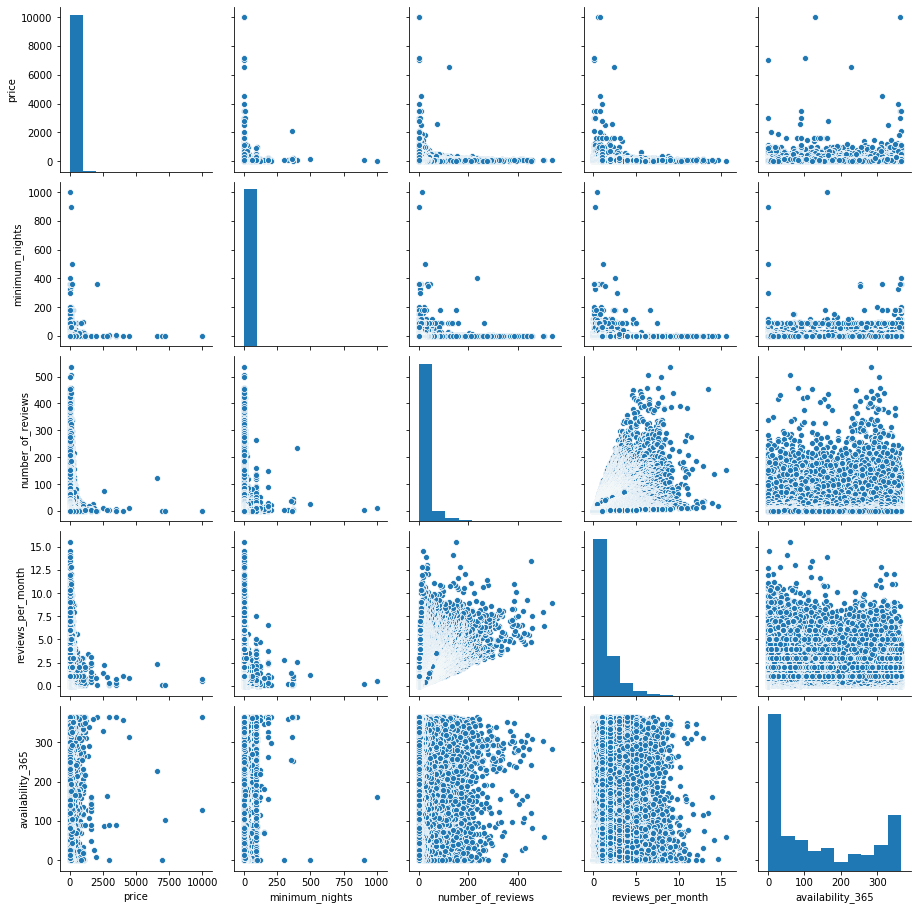

In [12]:
sns.pairplot(london[["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "availability_365"]])
plt.show()

## Elimino con .drop las columnas que no son de interes

In [13]:
london = london.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'last_review', 'latitude', 'longitude'], axis=1)
#Que features que eliminamos podrian llegar a ser utiles?

Link util -->
https://medium.com/@khadijamahanga/using-latitude-and-longitude-data-in-my-machine-learning-problem-541e2651e08c

In [14]:
london.head(3)

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Haringey,Private room,35,1,131,1.71,4,262
1,Ealing,Private room,70,2,2,0.07,6,62
2,Islington,Private room,45,1,14,0.14,2,364


## Reviso si los valores máximos de cada feature se condicen con el contexto

Con que objetivo queremos ver esta informacion?

In [15]:
np.max(london)

neighbourhood                     Westminster
room_type                         Shared room
price                                   10000
minimum_nights                           1000
number_of_reviews                         536
reviews_per_month                       15.56
calculated_host_listings_count           1034
availability_365                          365
dtype: object

## Obtengo los percentiles 97 de price y Minimum nights para filtrar outliers de estas features

In [16]:
price_q97 = london.price.quantile(0.975)
print("el cuantil 0.97 de la feature 'price' es = " + str(price_q97))

el cuantil 0.97 de la feature 'price' es = 300.0


In [17]:
min_nights_q97 = london.minimum_nights.quantile(0.975)
print("el cuantil 0.97 de la feature 'minimum_nights' es = " + str(min_nights_q97))

el cuantil 0.97 de la feature 'minimum_nights' es = 14.0


## Outlier Filtering: Filtro mi dataset por los percentiles calculados en el paso anterior bajo las features correspondientes

In [18]:
# aca filtro y conservo los valores que cumplen las dos condiciones al mismo tiempo
london_filt = london.loc[(london.price < price_q97) & (london.minimum_nights < min_nights_q97)]

In [19]:
london_filt.shape

(51827, 8)

In [20]:
london_filt.head(3)

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Haringey,Private room,35,1,131,1.71,4,262
1,Ealing,Private room,70,2,2,0.07,6,62
2,Islington,Private room,45,1,14,0.14,2,364


## Feature Engineering: Genero variables dummies para las features categoricas (Neighbourhood y Room Type)

In [21]:
# dummies para la feature "neighbourhood"
neighs_dummie = pd.get_dummies(london_filt.neighbourhood)
neighs_dummie.head(3)

,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,...,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
neighs_dummie.shape

(51827, 33)

In [23]:
# Ejemplo de dummies para la feature "room_type"
room_dummie = pd.get_dummies(london_filt.room_type)
room_dummie.head(3)

,Entire home/apt,Private room,Shared room
0,0,1,0
1,0,1,0
2,0,1,0


In [24]:
room_dummie.shape

(51827, 3)

## Agrego las nuevas variables dummies creadas al dataframe de trabajo 'london_filt'

In [25]:
london_filt = london_filt.join([neighs_dummie, room_dummie])

In [26]:
london_filt.head(3)

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Barking and Dagenham,Barnet,...,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,Entire home/apt,Private room,Shared room
0,Haringey,Private room,35,1,131,1.71,4,262,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Ealing,Private room,70,2,2,0.07,6,62,0,0,...,0,0,0,0,0,0,0,0,1,0
2,Islington,Private room,45,1,14,0.14,2,364,0,0,...,0,0,0,0,0,0,0,0,1,0


In [27]:
print("La cantidad de features nuevas agregadas a dataframe son = " + str(np.shape(neighs_dummie)[1]+np.shape(room_dummie)[1]))

La cantidad de features nuevas agregadas a dataframe son = 36


## Creamos nuestra variable dependiente (label - etiqueta) y

In [28]:
y = np.array(london_filt[["price"]])

## Creamos nuestra variable Independiente X quitando las features que no deseamos

In [29]:
x = london_filt.drop(['price', 'neighbourhood','room_type'], axis=1)

In [30]:
np.shape(x)

(51827, 41)

## Divido el dataset entre Train y Test

In [31]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.90, random_state=42)

In [32]:
xtrain.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,...,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,Entire home/apt,Private room,Shared room
4109,3,10,0.61,1,321,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8703,1,2,0.05,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
62456,4,1,0.94,1,137,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7200,2,2,0.18,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
44756,1,3,0.25,1,220,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [33]:
xtrain.shape

(5182, 41)

In [34]:
# Step 4: auto scaling train- set (mean = 0, std = 1)
scaler = preprocessing.StandardScaler().fit(xtrain)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [35]:
# auto scalo mis muestras de train utilizando el scaler fiteado con el xtrain
xtrain_scal = scaler.transform(xtrain)  

In [36]:
# auto scalo mis muestras de test utilizando el scaler fiteado con el xtrain
xtest_scal = scaler.transform(xtest)  

# Creo un modelo de Regresión Lineal

In [37]:
# 1) creo un modelo generico de regresion lineal
lr = LinearRegression()

In [38]:
# 2) Ajusto el modelo de regresion lineal utilizando el set de train, tanto las features X como las samples Y
lr.fit(xtrain_scal, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
# 3) Obtengo las predicciones que realiza mi modelo con las muestras de test, sin mostrarle las labels (Ytest)
# las predicciones las guardo en el vector "ypred"
ypred = lr.predict(xtest_scal)

In [40]:
np.shape(ypred)

(46645, 1)

In [41]:
# calculo el error de mi modelo con las muestras de train = error de train
np.sqrt(mean_squared_error(ytest, ypred))

39.299588589114684

In [42]:
mean_squared_error(ytest, ypred)

1544.457663273673

In [43]:
from sklearn.metrics import mean_absolute_error

In [44]:
mean_absolute_error(ytest, ypred)

28.085250295268555

![Inner join](https://i.imgflip.com/1vgxmu.jpg)

## Armar tres modelos de regresion usando:

    -KNN Regression
    Utilizar un GridSearchCV: como base podes utilizar los siguientes parametros
    parameters_k = np.arange(20,31,5)
    parameters_knn = [{'n_neighbors': parameters_k}]
    
    https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html?highlight=knn
    
    -SVR
    Utilizar un GridSearchCV: como base podes utilizar los siguientes parametros:
    ​parameters_svr_rbf = [{'kernel':['rbf'] , 'C': [1,100],'gamma': [0.1,0.5] }]
    
    -Random Forest regressor
    Utilizar un GridSearchCV: como base podes utilizar los siguientes parametros:
    'n_estimators': [100, 200, 300, 1000]
    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.set_params

### Comparar el R2, RMSE, MAE

Competencia

Mayor R2 = { }

Menor RMSE = { }

Menor MAE = { }

In [45]:
#SVR

est = SVR(max_iter=25000)
parameters_svr_rbf = [{'kernel':['rbf'] , 'C': [1,100],'gamma': [0.1,0.5] }]

parameters_svr_linear = [{'kernel':['linear'] , 'C': [0.1,1,100],}]

gs = GridSearchCV(est, param_grid=parameters_svr_linear,refit=True,
                  cv=5, scoring="neg_mean_squared_error",
                  verbose=3, n_jobs=3)

In [46]:
# Entrenamos
gs.fit(xtrain_scal, ytrain)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   14.0s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=25000, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=3,
             param_grid=[{'C': [0.1, 1, 100], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

In [47]:
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=25000, shrinking=True, tol=0.001, verbose=False) 

{'C': 1, 'kernel': 'linear'} 

-1666.4553191881066 



In [48]:
# Prediccion + Metricas

svr_prediction = gs.best_estimator_.predict(xtest_scal)
svr_r2 = r2_score(y_true=ytest, y_pred=svr_prediction)
svr_mse = mean_squared_error(y_true=ytest, y_pred=svr_prediction)
svr_mae = mean_absolute_error(y_true=ytest, y_pred=svr_prediction)

R2 score: 0.482524
MSE: 1620.763746
MAE: 26.921674


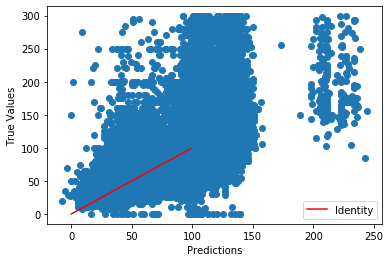

In [49]:
plt.scatter(svr_prediction, ytest)
plt.plot(np.arange(0,100),np.arange(0,100), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {svr_r2:.6f}')
print(f'MSE: {svr_mse:.6f}')
print(f'MAE: {svr_mae:.6f}')

In [50]:
#KNN Regression

  #https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

In [51]:
knn = KNeighborsRegressor()
knn.fit(xtrain,ytrain)
print('Train Score',knn.score(xtrain,ytrain))
print('Test Score',knn.score (xtrain,ytrain))

Train Score 0.39832975711256957
Test Score 0.39832975711256957


In [52]:
parameters_k = np.arange(20,31,5)
parameters_knn = [{'n_neighbors': parameters_k}]

In [53]:
gs_knn=GridSearchCV(knn,param_grid=parameters_knn,refit=True,
                  cv=5, scoring="neg_mean_squared_error",
                  verbose=3, n_jobs=3)



In [54]:
# Entrenamos
gs_knn.fit(xtrain_scal, ytrain)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:    2.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=3,
             param_grid=[{'n_neighbors': array([20, 25, 30])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

In [55]:
print(gs_knn.best_estimator_, "\n")
print(gs_knn.best_params_, "\n")
print(gs_knn.best_score_, "\n")

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                    weights='uniform') 

{'n_neighbors': 20} 

-1633.0440172967944 



In [56]:
# Prediccion + Metricas

knn_prediction = gs_knn.best_estimator_.predict(xtest_scal)
knn_r2 = r2_score(y_true=ytest, y_pred=knn_prediction)
knn_mse = mean_squared_error(y_true=ytest, y_pred=knn_prediction)
knn_mae = mean_absolute_error(y_true=ytest, y_pred=knn_prediction)

R2 score: 0.493432
MSE: 1586.600613
MAE: 28.067338


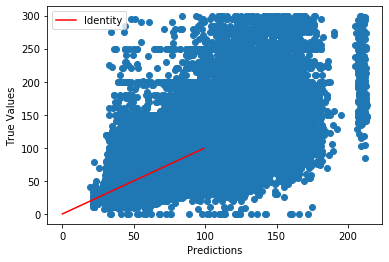

In [57]:
plt.scatter(knn_prediction, ytest)
plt.plot(np.arange(0,100),np.arange(0,100), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {knn_r2:.6f}')
print(f'MSE: {knn_mse:.6f}')
print(f'MAE: {knn_mae:.6f}')

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [59]:
#RFR Regression Random Forest regressor

rfr= RandomForestRegressor()

In [60]:
parameters_rfr = {'n_estimators': [100, 200, 300, 1000]}

In [61]:
gs_rfr = GridSearchCV(rfr, param_grid=parameters_rfr,refit=True,
                  cv=5, scoring="neg_mean_squared_error",
                  verbose=3, n_jobs=3)

In [62]:
#Entrenamos
gs_rfr.fit(xtrain_scal, ytrain)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  1.2min finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [63]:
print(gs_rfr.best_estimator_, "\n")
print(gs_rfr.best_params_, "\n")
print(gs_rfr.best_score_, "\n")

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) 

{'n_estimators': 1000} 

-1597.2263910982017 



In [64]:
# Prediccion + Metricas
rfr_prediction = gs_rfr.best_estimator_.predict(xtest_scal)
rfr_r2 = r2_score(y_true=ytest, y_pred=rfr_prediction)
rfr_mse = mean_squared_error(y_true=ytest, y_pred=rfr_prediction)
rfr_mae = mean_absolute_error(y_true=ytest, y_pred=rfr_prediction)

R2 score: 0.493432
MSE: 1586.600613
MAE: 28.067338


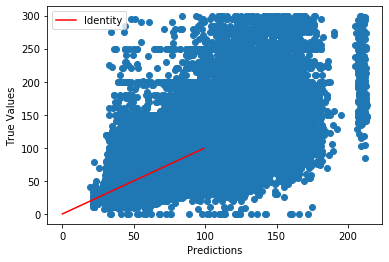

In [65]:
plt.scatter(knn_prediction, ytest)
plt.plot(np.arange(0,100),np.arange(0,100), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {knn_r2:.6f}')
print(f'MSE: {knn_mse:.6f}')
print(f'MAE: {knn_mae:.6f}')

In [66]:
results_df = pd.DataFrame(columns=['Model','R2','MSE','MAE'])
results_df

,Model,R2,MSE,MAE


In [67]:
results_df = results_df.append({'Model':'SVR',
                                'R2':svr_r2,
                                'MSE':svr_mse,
                                'MAE':svr_mae},ignore_index=True)

In [69]:
results_df = results_df.append({'Model':'KNN',
                                'R2':knn_r2,
                                'MSE':knn_mse,
                                'MAE':knn_mae},ignore_index=True)

In [70]:
results_df = results_df.append({'Model':'RFR',
                                'R2':rfr_r2,
                                'MSE':rfr_mse,
                                'MAE':rfr_mae},ignore_index=True)

In [71]:
results_df

,Model,R2,MSE,MAE
0,SVR,0.482524,1620.763746,26.921674
1,KNN,0.493432,1586.600613,28.067338
2,RFR,0.489364,1599.341289,28.113144
